In [1]:
import warnings
warnings.filterwarnings("ignore")

## 2. Modern Portfolio Theory (MPT)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rm

from hmmlearn import hmm
import pandas as pd

import sympy

In finance, a **portfolio**, inspired by Harry Markowitz, refers to a collection of financial assets such as 
- stocks, 
- bonds, 
- commodities, 
- cash and cash equivalents, and 
- ETFs, 

aimed at diversification to mitigate risk while maximizing returns.

**Returns**: Refers to the annualised gain or loss on our asset/portfolio over a fixed time frame. 
In this analysis, we make a return as the percentage change in the closing price of the asset over the previous day’s closing price.

The **modern portfolio theory (MPT)** is a mathematical framework that’s used to build a portfolio of assets that maximizes the expected return for the collective level of risk.

MPT does assume a normal distribution in returns. 
So the variance in the returns is considered to be normal. 
The Standard Deviation is often considered to be the *volatility* or *risk* involved with the investment. 
Just like returns, the standard deviation should be annualised over the 365.25 days in a year.

### `yfinance`

In [3]:
import yfinance as yf

In [13]:
monster = yf.Ticker("MNST").history(start="2023-09-01", end="2025-09-10", interval="3mo")
pepper = yf.Ticker("KDP").history(start="2023-09-01", end="2025-09-10", interval="3mo")
pepsi = yf.Ticker("PEP").history(start="2023-09-01", end="2025-09-10", interval="3mo")
coke = yf.Ticker("COKE").history(start="2023-09-01", end="2025-09-10", interval="3mo")
nvidia = yf.Ticker("NVDA").history(start="2023-09-01", end="2025-09-10", interval="3mo")

In [17]:
portfolio = pd.DataFrame({
    "COKE": coke.Close,
    "NVDA": nvidia.Close,
    # "PEP": pepsi.Close,
    # "COKE": coke.Close
})
portfolio.head(2)

,COKE,NVDA
Date,,
2023-09-01 00:00:00-04:00,71.226814,46.738602
2023-12-01 00:00:00-05:00,81.596344,79.065399


In [18]:
portfolio_returns = portfolio.pct_change()
portfolio_returns.head()

,COKE,NVDA
Date,,
2023-09-01 00:00:00-04:00,NaN,NaN
2023-12-01 00:00:00-05:00,0.145585,0.691651
2024-03-01 00:00:00-05:00,0.189247,0.385917
2024-06-01 00:00:00-04:00,0.369156,0.088865
2024-09-01 00:00:00-04:00,-0.027949,0.158259


In [19]:
portfolio_returns.mean()

COKE    0.075158
NVDA    0.208815
dtype: float64

In [24]:
portfolio_returns.std()

COKE    0.166141
NVDA    0.243796
dtype: float64

In [25]:
cov_matrix = portfolio_returns.cov()
cov_matrix

,COKE,NVDA
COKE,0.027603,0.008528
NVDA,0.008528,0.059437


In [29]:
cov_matrix.loc['COKE', 'COKE']

np.float64(0.027602862595498375)

In [30]:
cov_matrix.loc['COKE', 'NVDA']

np.float64(0.008527558451344817)

### `sympy`

In [ ]:
x = sympy.symbols('x')

In [ ]:
cov_matrix = np.array([[0.1**2, 0.5*0.1*0.2], [0.5*0.1*0.2, 0.2**2]])
nu = np.array([x, 1-x])
mu = 0.2*x + (1-x)*0.3
sigmas = np.transpose(nu) @ cov_matrix @ nu

In [ ]:
sympy.simplify(sigmas)

In [ ]:
sympy.solve(sympy.diff(sigmas, x), x)

In [ ]:
sympy.simplify(mu - mu**2 - sigmas)

In [ ]:
sympy.solve(sympy.diff(mu - mu**2 - sigmas, x), x)

### Portfolio

#### 2D Visualization

In [26]:
t = np.linspace(0, 1, num=100, endpoint=True)

In [33]:
r = t*portfolio_returns.COKE.mean() + (1-t)*portfolio_returns.NVDA.mean()
sigma = np.sqrt(t*cov_matrix.loc['COKE', 'COKE'] + (1-t)*cov_matrix.loc['NVDA', 'NVDA'] + 2*t*(1-t)*cov_matrix.loc['COKE', 'NVDA'])

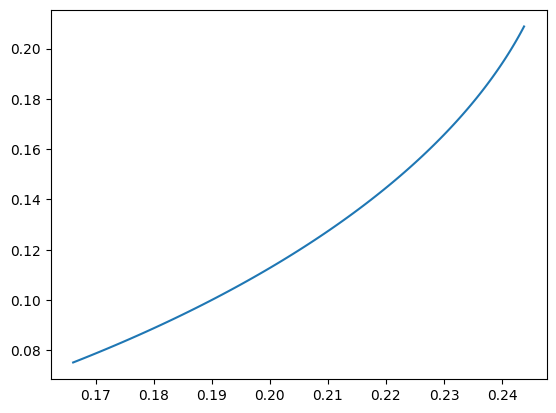

In [34]:
plt.plot(sigma, r)
plt.show()

#### 3D Visulization

In [5]:
import itertools

In [9]:
t1 = np.linspace(0, 1, num=100, endpoint=True)
t2 = np.linspace(0, 1, num=100, endpoint=True)

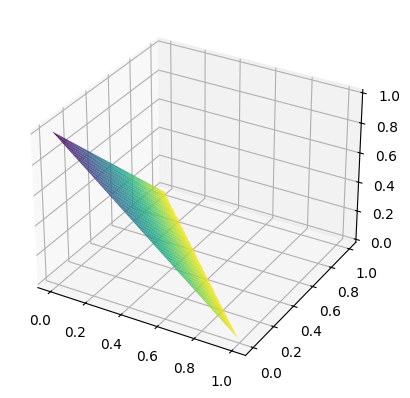

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(t1, t2)
Z = 1 - X - Y
Z[Z<0] = np.nan
ax.plot_surface(X, Y, np.maximum(Z,0), cmap='viridis_r', label='P')
# ax.plot_surface(X, Y, 0*Z, cmap='plasma', label='z=0')


In [11]:
type(Z)

numpy.ndarray

In [15]:
Z[Z<0] = np.nan

In [66]:
z = np.array(list(itertools.product(t1, t2)))
z

array([[0.        , 0.        ],
       [0.        , 0.01010101],
       [0.        , 0.02020202],
       ...,
       [1.        , 0.97979798],
       [1.        , 0.98989899],
       [1.        , 1.        ]], shape=(10000, 2))

In [59]:
t3 = 1 - z[:, 0] - z[:, 1]

In [63]:
len(t3)

10000

In [62]:
len(t3[t3 >= 0])

4966

#### Example

In [88]:
ts = np.linspace(0, 1, num=50, endpoint=True)
corrs = np.linspace(-1, 1, num=20, endpoint=True)

In [89]:
sigmas = dict()
mus = dict()

for t in ts:
    for corr in corrs:
        cov_matrix = np.array([[0.15**2, corr*0.15*0.45], [corr*0.15*0.45, 0.45**2]])
        nu = np.array([t, 1-t])
        sigmas[(t, corr)] = np.sqrt(np.transpose(nu) @ cov_matrix @ nu)
        mus[(t, corr)] = 0.12*t+(1-t)*0.2

In [90]:
df = pd.DataFrame({"sigma": sigmas, "mu": mus}).reset_index()
df.columns = ['t', 'corr', 'std', 'mean']
df.head(2)

,t,corr,std,mean
0,0.0,-1.000000,0.45,0.2
1,0.0,-0.894737,0.45,0.2


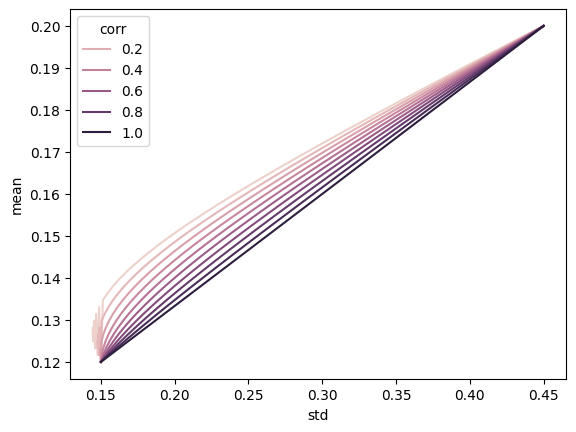

In [93]:
sns.lineplot(data=df[df['corr']>=0], x="std", y="mean", hue="corr")
# plt.title("Passengers over Years by Month")
plt.show()

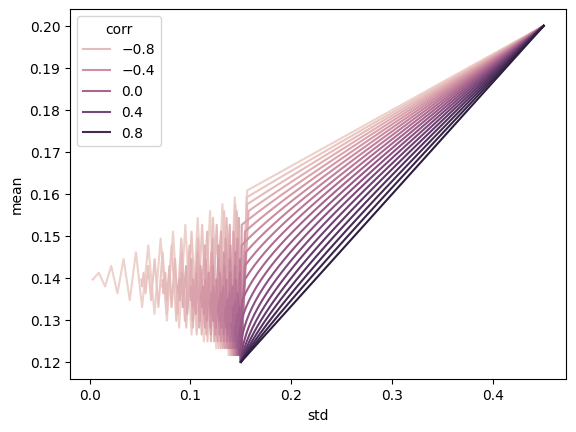

In [94]:
sns.lineplot(data=df, x="std", y="mean", hue="corr")
# plt.title("Passengers over Years by Month")
plt.show()

In [29]:
cov_matrix = np.array([[0.15**2, -0.15*0.45], [-0.15*0.45, 0.45**2]])
nu = np.array([0.1, 0.9])
print(np.transpose(nu) @ cov_matrix @ nu, np.sqrt(np.transpose(nu) @ cov_matrix @ nu))

0.1521 0.39


In [31]:
cov_matrix = np.array([[0.15**2, -0.15*0.45], [-0.15*0.45, 0.45**2]])
nu = np.array([0.4, 0.6])
print(np.transpose(nu) @ cov_matrix @ nu, np.sqrt(np.transpose(nu) @ cov_matrix @ nu))

0.0441 0.21


In [27]:
np.transpose(nu) @ cov_matrix @ nu

np.float64(0.35385000000000005)

In [126]:
cov_matrix = np.array([[0.2**2, 0.5*0.2*0.3], [0.5*0.2*0.3, 0.3**2]])

ts = ts = np.linspace(0, 1, num=150, endpoint=True)

# stds = dict()
stds = []

for t in ts:
    nu = np.array([t, 1-t])
    stds.append( np.transpose(nu) @ cov_matrix @ nu)

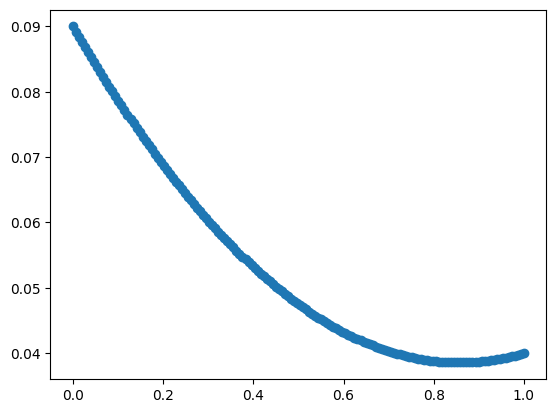

In [127]:
plt.scatter(x=ts, y= stds)
plt.show()


### Efficient Frontier

In the MPT, the **efficient frontier** is a curve denoting the efficient part of the **volatility-return plane**. 
Formally, it is the set of portfolios that can be constructed with the given input assets that have the maximum expected returns for a fixed level of volatility and, in turn, the lowest volatilities for a fixed level of expected return. 
The efficient frontier was first formulated by Harry Markowitz (1952).

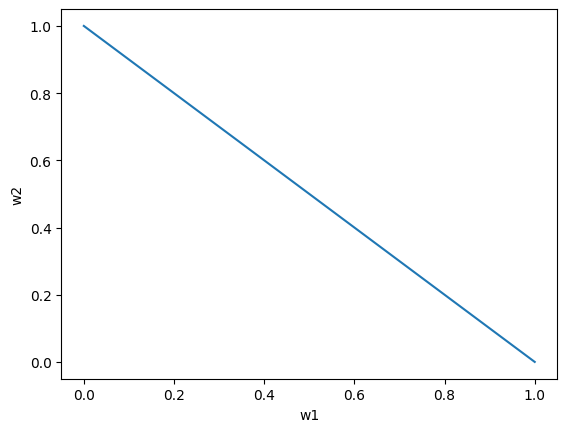

In [3]:
t = np.linspace(0, 1, 200)

plt.plot(t, 1-t)
plt.xlabel("w1")
plt.ylabel("w2")
plt.show()

### Martingales

Consider the Binomial asset-pricing model. 
Let $M_0, M_1, ..., M_N$ be a sequence of random variables, with each $M_n$ depending only on the first $n$ coin tosses (and $M_0$ constan).
Such a sequence oof random variables is called an **adapted stochastic process**.

If 
$$M_n = \mathbb{E}_n[M_{n+1}], \ \ \ n=0, 1, ..., N-1,$$
we say this process is a **martingale**.

If 
$$M_n \leq \mathbb{E}_n[M_{n+1}], \ \ \ n=0, 1, ..., N-1,$$
we say this process is a **submartingale** (even though it may have a tendency to increase).

If 
$$M_n \geq \mathbb{E}_n[M_{n+1}], \ \ \ n=0, 1, ..., N-1,$$
we say this process is a **supermartingale** (even though it may have a tendency to decrease).

In [ ]:
# Define the risk-free bond and the risky stock with their respective prices in two states
B = np.array([10, 10])  # Risk-free bond price remains the same in both states
S = np.array([20, 5])  # Risky stock price in an upward state and a downward state

In [ ]:
# The contingent claim we aim to replicate
C1 = np.array([15, 5])  # Payoff of the contingent claim in upward and downward states

# The matrix representing the price processes of the bond and the stock
M = np.array([[B[0], S[0]], [B[1], S[1]]])

In [ ]:
# Solving the replication problem
# We aim to find portfolio weights (phi) such that M * phi = C1
phi = np.linalg.solve(M, C1)

print(f"The replication portfolio weights are: {phi}")